Load Time-Series Data

In [1]:
import pandas as pd

data = pd.read_csv("../data/processed data/monthly_sales.csv", index_col=0, parse_dates=True)
data.head()


,Sales,Category,Region
Order Date,,,
2015-01-31,14205.707,Office SuppliesOffice SuppliesOffice SuppliesO...,CentralCentralCentralCentralEastWestSouthSouth...
2015-02-28,4519.892,TechnologyOffice SuppliesOffice SuppliesTechno...,CentralWestSouthSouthWestWestWestWestWestSouth...
2015-03-31,55205.797,FurnitureTechnologyFurnitureOffice SuppliesOff...,WestEastCentralCentralCentralCentralCentralCen...
2015-04-30,27906.855,Office SuppliesOffice SuppliesOffice SuppliesO...,WestWestEastEastSouthSouthSouthCentralCentralS...
2015-05-31,23644.303,Office SuppliesTechnologyOffice SuppliesOffice...,EastSouthCentralEastEastCentralEastCentralCent...


Prepare Data for Prophet

In [4]:
df = data.reset_index()

# Keep only Date and Sales
df = df[["Order Date", "Sales"]] if "Order Date" in df.columns else df.iloc[:, [0, 1]]

# Rename for Prophet
df.columns = ["ds", "y"]

df.head()


,ds,y
0,2015-01-31,14205.707
1,2015-02-28,4519.892
2,2015-03-31,55205.797
3,2015-04-30,27906.855
4,2015-05-31,23644.303


In [6]:
from prophet import Prophet

model = Prophet()
model.fit(df)


21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:35 - cmdstanpy - INFO - Chain [1] done processing


Generate Sales Forecast

In [7]:
# Create future dates (next 60 months)
future = model.make_future_dataframe(periods=60, freq="M")

# Predict
forecast = model.predict(future)

forecast.head()


C:\Users\Annie Valentina\AppData\Roaming\Python\Python313\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-31,33505.686141,4710.675504,22654.573629,33505.686141,33505.686141,-19204.897511,-19204.897511,-19204.897511,-19204.897511,-19204.897511,-19204.897511,0.0,0.0,0.0,14300.788630
1,2015-02-28,33906.289832,-6567.882642,11891.497526,33906.289832,33906.289832,-31613.799057,-31613.799057,-31613.799057,-31613.799057,-31613.799057,-31613.799057,0.0,0.0,0.0,2292.490775
2,2015-03-31,34349.815347,43513.449305,61347.133293,34349.815347,34349.815347,17667.105678,17667.105678,17667.105678,17667.105678,17667.105678,17667.105678,0.0,0.0,0.0,52016.921025
3,2015-04-30,34779.033587,11479.900154,31052.135144,34779.033587,34779.033587,-13655.620453,-13655.620453,-13655.620453,-13655.620453,-13655.620453,-13655.620453,0.0,0.0,0.0,21123.413134
4,2015-05-31,35222.559103,13005.185833,32158.372112,35222.559103,35222.559103,-12496.061322,-12496.061322,-12496.061322,-12496.061322,-12496.061322,-12496.061322,0.0,0.0,0.0,22726.497781


Plot Forecast

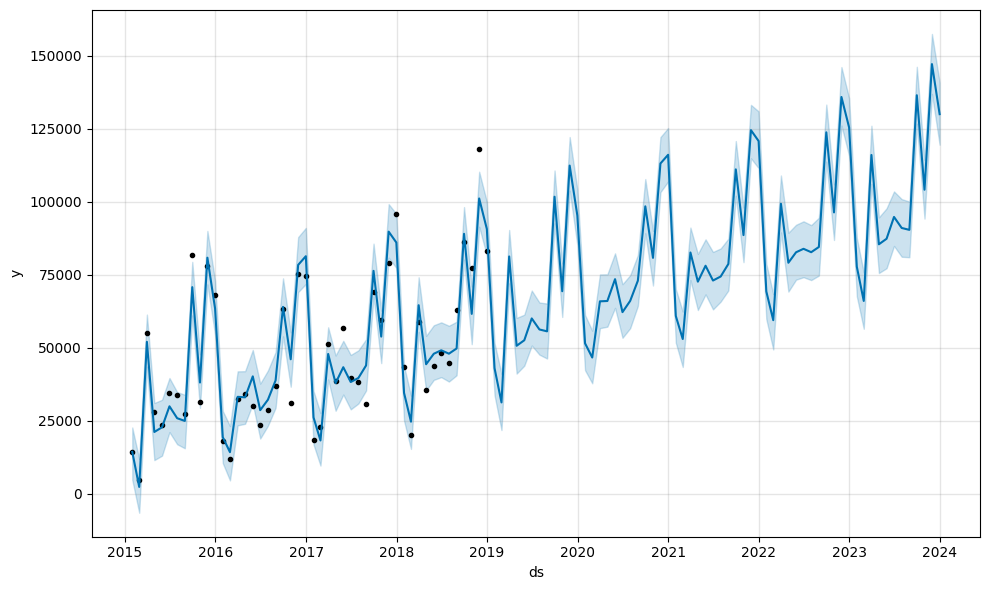

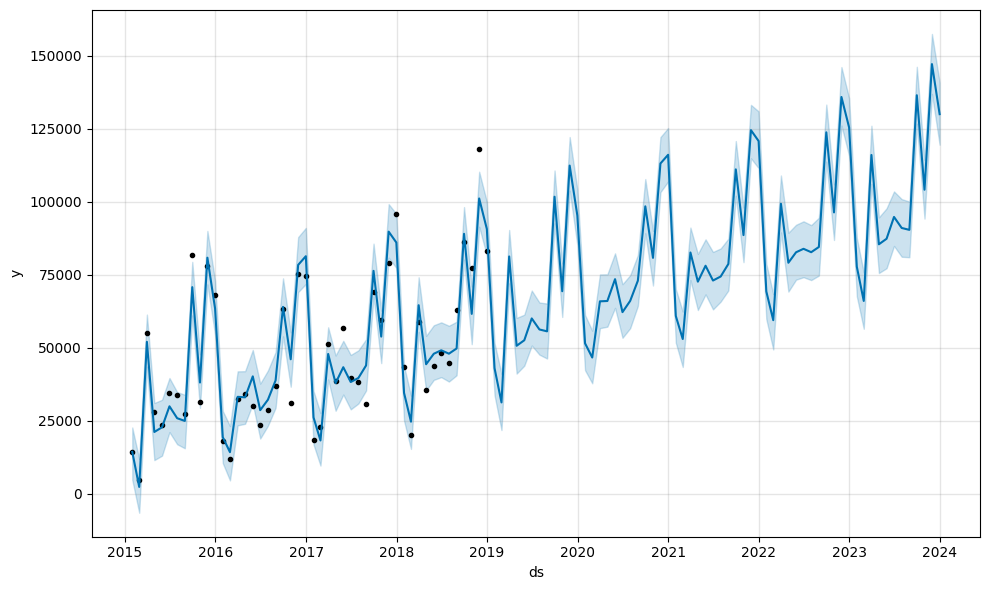

In [8]:
model.plot(forecast)


In [10]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv("../data/processed data/forecast.csv", index=False)


Model Evaluation

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge forecast with actuals
actual = df.copy()
predicted = forecast[["ds", "yhat"]]

merged = actual.merge(predicted, on="ds", how="inner")

# Calculate metrics
mae = mean_absolute_error(merged["y"], merged["yhat"])
rmse = np.sqrt(mean_squared_error(merged["y"], merged["yhat"]))
mape = np.mean(np.abs((merged["y"] - merged["yhat"]) / merged["y"])) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape, "%")


MAE: 5770.415946784901
RMSE: 7272.004220576394
MAPE: 14.482661931976429 %


Future Sales (Next 60 Months)

In [12]:
future_forecast = forecast[forecast["ds"] > df["ds"].max()]

future_forecast[["ds", "yhat"]].head()


,ds,yhat
48,2019-01-31,42990.532201
49,2019-02-28,31248.159920
50,2019-03-31,81267.007771
51,2019-04-30,50658.420139
52,2019-05-31,52555.922385


Expected Growth

In [13]:
current_sales = df["y"].tail(12).mean()
future_sales = future_forecast["yhat"].head(12).mean()

growth = ((future_sales - current_sales) / current_sales) * 100
print("Expected annual growth:", growth, "%")


Expected annual growth: 12.092417903056917 %


High Demand Months (Seasonality)

In [14]:
future_forecast["Month"] = future_forecast["ds"].dt.month
peak_months = future_forecast.groupby("Month")["yhat"].mean().sort_values(ascending=False)

peak_months.head()


C:\Users\Annie Valentina\AppData\Local\Temp\ipykernel_17212\4125261120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast["Month"] = future_forecast["ds"].dt.month


Month
11    126640.073286
12    117534.202649
9     114322.834517
3      89032.738241
10     87846.183106
Name: yhat, dtype: float64

Low Demand Months

In [15]:
peak_months.tail()


Month
6    74789.551721
7    74090.613246
4    70769.928862
1    60487.785239
2    51263.920757
Name: yhat, dtype: float64

Category Performance

In [16]:
raw = pd.read_csv("../data/raw data/train.csv")

category_perf = raw.groupby("Category")["Sales"].sum().sort_values(ascending=False)
category_perf


Category
Technology         827455.8730
Furniture          728658.5757
Office Supplies    705422.3340
Name: Sales, dtype: float64